In [6]:
%matplotlib inline

import json
import pandas as pd
import wandb


In [7]:
def get_training_data(project, run_name, filename):
    dfs = []
    for r in wandb.Api().runs(project):
        if r.name == run_name:
            cfg = json.loads(r.json_config)
            for f in r.files():
                if f.name == filename:
                    print("MATCH", f.name)
                    print("loading", f.name, " from ", r.name)
                    root = "/tmp"
                    f.download(root, replace=True)
                    path = f"{root}/{f.name}"
                    df = pd.read_json(path, lines=True)
                    df["acquire_pairs_function"] = cfg["exp5"]["value"]["acquire_pairs_function"]
                    df["seed"] = int(cfg["seed"]["value"])
                    df["m"] = int(f.name.split("_")[2][1:].split(".")[0])
                    df["run_name"] = r.name
                    df["oracle_model_agree"] = df.apply(lambda x: 1 if x['r_hats'][x['rank'][0]] > x['r_hats'][x['rank'][1]] else 0, axis=1)
                    df["r_margin"] = df.apply(lambda x: abs(x["r_hats"][0] - x["r_hats"][1]), axis=1)
                    dfs.append(df)

    return pd.concat(dfs)


In [8]:

# Oh dear - deleted this imdb run...
#df_imdb = get_training_data("bbnn/wm-apl-imdb", "polished-aardvark-81", "training_data_m1024.jsonl")
df_tldr = get_training_data("bbnn/wm-apl-tldr", "polar-frost-237", "training_data_m768.jsonl")

MATCH training_data_m768.jsonl
loading training_data_m768.jsonl  from  polar-frost-237


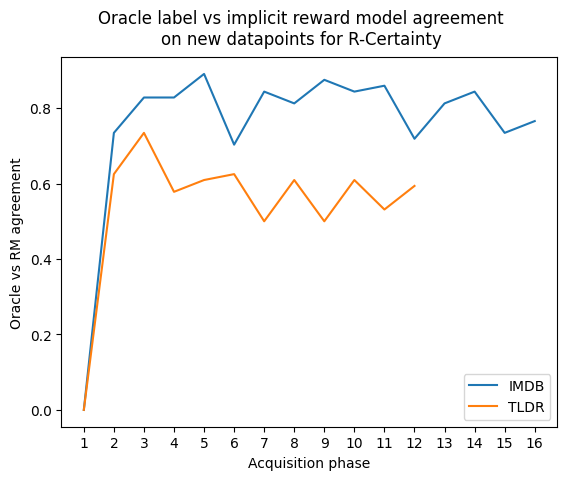

In [21]:


import matplotlib.pyplot as plt


df_imdb.groupby("target_m")["oracle_model_agree"].mean().plot()
df_tldr.groupby("target_m")["oracle_model_agree"].mean().plot()
plt.legend(["IMDB", "TLDR"], loc="lower right")
plt.ylabel("Oracle vs RM agreement")
plt.xlabel("Acquisition phase")
plt.xticks(list(range(64, 1025, 64)), [x // 64 for x in range(64, 1025, 64)])

plt.suptitle("Oracle label vs implicit reward model agreement\non new datapoints for R-Certainty")
plt.savefig("oracle_v_rm_certainty.png")